In [120]:
from importlib import reload
import COVID19 as cov
reload(cov)
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 根据原始数据生成模型
covmodel = cov.COVID19()

# 导入已有数据

In [100]:
covmodel = cov.COVID19(loadpath='auto')
covmodel.loadfit()
covmodel.simulate()
covmodel.compute_influence_matrix()

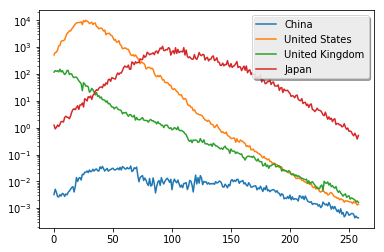

In [101]:
covmodel.plot_exports(names=['China', 'United States', 'United Kingdom', 'Japan'])

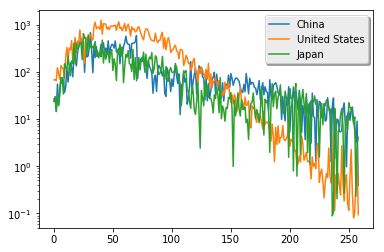

In [91]:
covmodel.plot_imports(names=['China', 'United States', 'Japan'])

In [157]:
china=np.r_[covmodel.all_trajectories[:, covmodel.nodes['China'], 1] ,\
            covmodel.result[1:, len(covmodel.nodes)+covmodel.nodes['China']]]
usa=np.r_[covmodel.all_trajectories[:, covmodel.nodes['United States'], 1] ,\
            covmodel.result[1:, len(covmodel.nodes)+covmodel.nodes['United States']]]

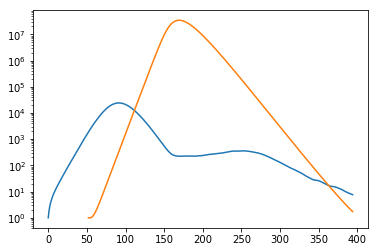

In [158]:
plt.semilogy(china*covmodel.population[covmodel.nodes['China']])
plt.semilogy(usa*covmodel.population[covmodel.nodes['United States']])
plt.show()

In [189]:
class COVID19Control(cov.COVID19):
    def __init__(self):
        super(COVID19Control, self).__init__(loadpath='auto')
        
        self.R_targets = np.zeros(len(self.nodes)) + 0.01 # 各国目标R为0.01
        self.import_control = np.zeros(len(self.nodes)) + 1 # 各国入关控制为0.1，即10%的感染者无法被测出
        self.export_control = np.zeros(len(self.nodes)) + 1
    
    def set_import_control(self, name, value):
        if name=='all':
            self.import_control = self.import_control * 0 + value
            return
        self.import_control[self.nodes[name]] = value
        
    def set_export_control(self, name, value):
        if name == 'all':
            self.export_control = self.export_control * 0 + value
            return
        self.export_control[self.nodes[name]] = value
    
    def _control_fij_import(self, fij):
        #self.import_control 会线性乘在fij的纵列（j）上
        return ((fij * self.import_control).T * self.export_control).T
    def _intervention(self, parameters,t):
        epsilon = parameters['epsilon']
        lambd = parameters['lambds']
        t0 = parameters['t0s']
        tstar = parameters['tstar']
        lambd2 = parameters['lambds2']
        exp1 = np.exp(lambd * (t - t0) - np.log(1/epsilon-1))
        decay = 1/(1+exp1)
        if tstar>0:
            #tstar = x0 + np.log((1-relax*epsilon)/(relax*epsilon+eta-1))
            exp2 = np.exp(lambd * (2*tstar - t - t0) - np.log(1/epsilon-1))
            decay1 += 1/(1+exp2) # TODO：没有定义
        return decay
    def _np_ode(self, states, t, parameters, fijt, population):
        # 重写_no_ode，控制防疫策略
        #print(t, states[0])
        sz = states.shape[0] // 5
        us = states[:sz] # 未确诊感染者
        cs = states[sz:2*sz] # 确诊
        ss = states[2*sz:3*sz] # 易感
        interval = parameters['interval'] # 时间步长
        tidx = int(t * interval) # 此刻对应的index
        if tidx >= len(fijt):
            fij = fijt[len(fijt)-1]
        else:
            fij = fijt[tidx] # 流量矩阵
        controled_fij = self._control_fij_import(fij)
        uterm = (us * population).dot(controled_fij) / population - us * np.sum(controled_fij,1) # 感染者的流动
        #self._control_uterm(uterm) #控制流动
        sterm = (ss * population).dot(fij) / population - ss * np.sum(fij,1) # 易感者的流动
        beta = parameters['beta']
        t_c = parameters['tc']
        t_r = parameters['tr']
        alphas = parameters['alphas']
        cross_term = beta * us * ss * self._intervention(parameters, t)
        #cross_term = beta * us * ss
        delta_u = cross_term - us / t_c + uterm
        delta_c = alphas * us / t_c - cs / t_r 
        delta_s = - cross_term + sterm
        domestic = cross_term
        virus_influx = (us * population).dot(fij) / population
        output = np.r_[delta_u, delta_c, delta_s, virus_influx, domestic]
        #records1.append(np.r_[delta_u, delta_c, delta_s])
        #records2.append(np.r_[us, cs, ss])
        return output

In [199]:
covmodel = COVID19Control()
#covmodel.set_import_control('China', 0.01)
#covmodel.set_export_control('United States', 0.01)
covmodel.loadfit()
covmodel.simulate()
#covmodel.compute_influence_matrix()

In [200]:
covmodel.set_export_control('United States', 0.0)
covmodel.set_export_control('Japan', 0.0)
covmodel.set_export_control('France', 0.0)
covmodel.set_import_control('all', 0.0)
covmodel.simulate()
covmodel.compute_influence_matrix()

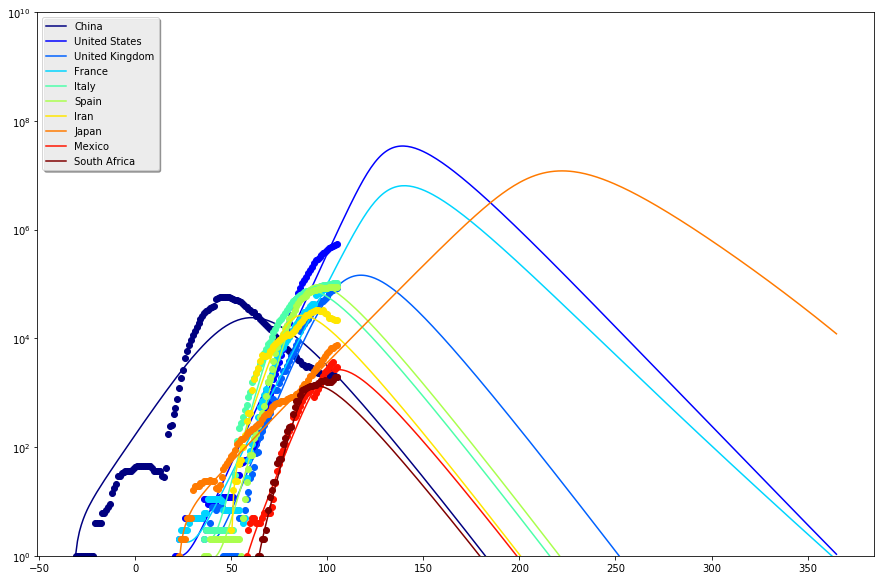

In [201]:
covmodel.plot_simulation()

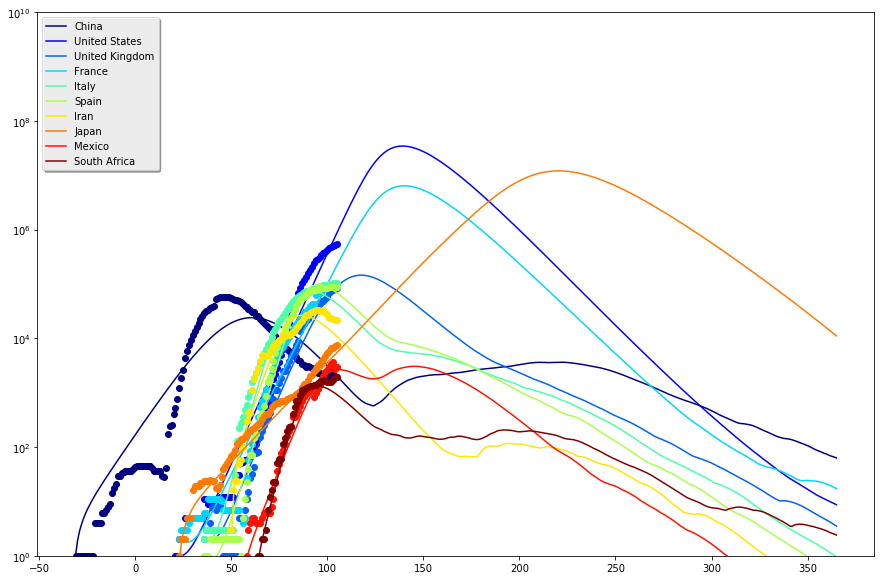

In [141]:
covmodel.plot_simulation()

In [1]:
help(covmodel.plot_simulation)

NameError: name 'covmodel' is not defined